In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

pd.set_option('display.float_format', '{:.4f}'.format)

# **Ejercicio 1:** Equity

In [2]:
tickers = ['KO','PEP','V','MA','XOM','CVX','JPM','BAC']

positions = {
    'KO': -125312,
    'PEP': 59350,
    'V': 30660,
    'MA': -18804,
    'XOM': -66386,
    'CVX': 54504,
    'JPM': 33003,
    'BAC': -189680
}

data = yf.download(tickers, start='2024-02-12', end='2026-02-12', progress=False)['Close']
returns = data.pct_change().dropna()

C:\Users\Isabela\AppData\Local\Temp\ipykernel_25636\1375737368.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2024-02-12', end='2026-02-12', progress=False)['Close']


In [3]:
latest_prices = data.iloc[-1]

# Valor de cada posición
values = pd.Series(positions) * latest_prices

# Valor total del portafolio
portfolio_value = sum([abs(x) for x in values.tolist()])

# Pesos de cada activo
weights = values / portfolio_value
weights = weights.to_frame(name='Peso (%)')
weights * 100

,Peso (%)
BAC,-12.6183
CVX,12.5116
JPM,12.6723
KO,-12.1677
MA,-12.4850
PEP,12.4018
V,12.4703
XOM,-12.6731


In [4]:
# Retornos del portafolio
portfolio_returns = returns.dot(weights)

# P&L
portfolio_pnl = portfolio_returns * portfolio_value

VaR_95 = np.percentile(portfolio_pnl, 5)
print("VaR histórico 1 día 95%:", VaR_95)

VaR histórico 1 día 95%: -320162.415226902


**Por qué se sigue teniendo riesgo?**

Aunque el portafolio tiene posiciones largas y cortas en igual proporción, el riesgo no desaparece porque la cobertura no es perfecta. Las acciones dentro de cada par no están perfectamente correlacionadas, sus volatilidades son distintas y reaccionan de forma diferente a factores macroeconómicos.

In [5]:
volume = yf.download(tickers, start='2025-11-12', end='2026-02-13', progress=False)['Volume']
avg_volume = volume.mean()

C:\Users\Isabela\AppData\Local\Temp\ipykernel_25636\599530687.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  volume = yf.download(tickers, start='2025-11-12', end='2026-02-13', progress=False)['Volume']


In [6]:
liquidity_check = {}

for ticker in tickers:
    shares = abs(positions[ticker])
    max_daily_trade = 0.10 * avg_volume[ticker]
    days_needed = shares / max_daily_trade
    liquidity_check[ticker] = days_needed

liquidity = pd.DataFrame.from_dict(liquidity_check, orient='index', columns=['Days to Liquidate'])
liquidity['Cumple ?'] = liquidity['Days to Liquidate'] < 2

liquidity

,Days to Liquidate,Cumple ?
KO,0.0698,True
PEP,0.0703,True
V,0.0416,True
MA,0.0551,True
XOM,0.0364,True
CVX,0.0518,True
JPM,0.0314,True
BAC,0.0494,True


**Conclusión:** Todas las posiciones pueden liquidarse dentro de 2 días

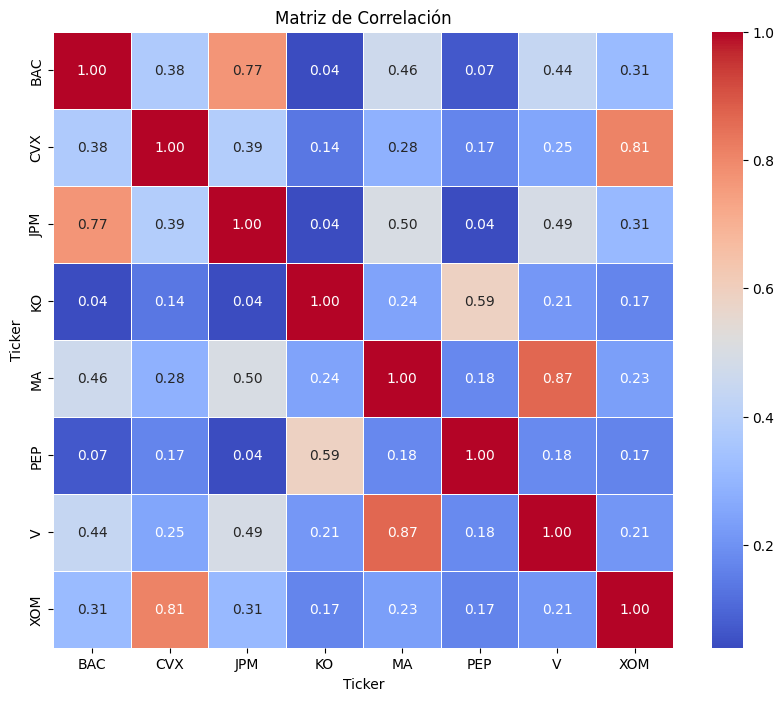

In [7]:
corr_matrix = returns.corr()
plt.figure(figsize=(10,8))

sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=0.5)

plt.title("Matriz de Correlación")
plt.show()

In [8]:
alt = {
    'BAC': -0.10,
    'CVX':  0.15,
    'JPM':  0.10,
    'KO':  -0.05,
    'MA':  -0.20,
    'PEP':  0.05,
    'V':    0.20,
    'XOM': -0.15
}

weights_alt = pd.DataFrame.from_dict(alt, orient='index', columns=['w'])
portfolio_returns = returns.dot(weights_alt)
portfolio_pnl = portfolio_returns * portfolio_value

VaR_95 = np.percentile(portfolio_pnl, 5)
print("VaR histórico 1 día 95% con nuevas ponderaciones:", VaR_95)

VaR histórico 1 día 95% con nuevas ponderaciones: -307356.16156001214


**Razonamiento:** Con base en la matriz de correlación observada, se decidió modificar las ponderaciones del portafolio asignando mayor peso a aquellos pares que presentan correlaciones más altas (por ejemplo, MA–V y CVX–XOM), ya que una mayor correlación implica que ambos activos tienden a moverse de manera más similar, reduciendo la volatilidad del spread entre la posición larga y la corta. En lugar de mantener ponderaciones uniformes, se incrementó la exposición en estos pares más correlacionados y se redujo en aquellos con menor relación estadística, buscando una cobertura más eficiente. Como resultado de este ajuste, el VaR histórico a 1 día al 95% disminuyó aproximadamente en 15,000 dólares (de alrededor de -315,350 a -301,660), evidenciando una reducción efectiva del riesgo del portafolio sin alterar su estructura long-short ni su exposición absoluta total.

**¿Cómo modificaría las ponderaciones en cada par buscando reducir el riesgo aun más?**  



# **Ejercicio 2:** Divisas

In [11]:
usd = pd.read_excel('USDMXN.xlsx', skiprows=2)
eur = pd.read_excel('EURMXN.xlsx', skiprows=2)

In [12]:
for col in ['Bid', 'Ask', 'Mid']:
    usd[col] = pd.to_numeric(usd[col], errors='coerce')
    eur[col] = pd.to_numeric(eur[col], errors='coerce')

usd['Date'] = pd.to_datetime(usd['Date'])
eur['Date'] = pd.to_datetime(eur['Date'])

usd = usd.sort_values('Date').reset_index(drop=True)
eur = eur.sort_values('Date').reset_index(drop=True)

In [13]:
# RENDIMIENTOS ARITMÉTICOS CON MID
usd['rend'] = usd['Mid'].pct_change()
eur['rend'] = eur['Mid'].pct_change()

usd = usd.dropna(subset=['rend']).reset_index(drop=True)
eur = eur.dropna(subset=['rend']).reset_index(drop=True)

N = 500
usd_500 = usd.tail(N).reset_index(drop=True)
eur_500 = eur.tail(N).reset_index(drop=True)

In [14]:
# MERGE Y PONDERACIONES
merged = pd.merge(usd_500[['Date','rend','Bid','Ask','Mid']],
                  eur_500[['Date','rend','Bid','Ask','Mid']],
                  on='Date', suffixes=('_usd','_eur'))

total = 7_000_000
w_usd = -4/7
w_eur =  3/7

In [15]:
# RENDIMIENTO DEL PORTAFOLIO
merged['rend_port'] = w_usd * merged['rend_usd'] + w_eur * merged['rend_eur']

In [16]:
# VaR HISTÓRICO AL 95%
var_pct = np.percentile(merged['rend_port'], 5)
var_dinero = var_pct * total

print(f"VaR en %:      {var_pct:.6f} ({var_pct*100:.4f}%)")
print(f"VaR en dinero: ${var_dinero:,.2f}")

VaR en %:      -0.003568 (-0.3568%)
VaR en dinero: $-24,977.99


In [19]:
# COSTO DE LIQUIDEZ
merged['spread_usd'] = (merged['Ask_usd'] - merged['Bid_usd']) / merged['Mid_usd']
merged['spread_eur'] = (merged['Ask_eur'] - merged['Bid_eur']) / merged['Mid_eur']

merged['spread_port'] = (4/7) * merged['spread_usd'] + (3/7) * merged['spread_eur']

mu_spread = merged['spread_port'].mean()
sigma_spread = merged['spread_port'].std()
z = norm.ppf(0.95)

lc = 0.5 * (mu_spread + z * sigma_spread)

print(f"\nμ spread:  {mu_spread:.6f}")
print(f"σ spread:  {sigma_spread:.6f}")
print(f"z (95%):   {z:.4f}")
print(f"LC = 0.5*(μ + z*σ) = {lc:.6f}")


μ spread:  0.000323
σ spread:  0.000084
z (95%):   1.6449
LC = 0.5*(μ + z*σ) = 0.000230


In [20]:
# L-VaR

lvar_pct = var_pct - lc
lvar_dinero = lvar_pct * total

print(f"\nL-VaR en %: {lvar_pct*100:.4f}%")
print(f"L-VaR en dinero: ${lvar_dinero:,.2f}")


L-VaR en %: -0.3799%
L-VaR en dinero: $-26,590.64


In [21]:
# STRESS TEST
mu_port = merged['rend_port'].mean()
sigma_port = merged['rend_port'].std()

stress_3s = mu_port - 3 * sigma_port
stress_3s_dinero = stress_3s * total

print(f"\nSTRESS TEST A) 3 Sigmas:")
print(f"  μ-3σ = {stress_3s:.6f} -> ${stress_3s_dinero:,.2f}")

print(f"\nSTRESS TEST B) 3 peores días históricos:")
worst = merged.nsmallest(3, 'rend_port')[['Date','rend_usd','rend_eur','rend_port']]
for _, row in worst.iterrows():
    print(f"  {row['Date'].date()}: {row['rend_port']:.6f} -> ${row['rend_port']*total:,.2f}")


STRESS TEST A) 3 Sigmas:
  μ-3σ = -0.007338 -> $-51,367.52

STRESS TEST B) 3 peores días históricos:
  2025-04-04: -0.009584 -> $-67,089.99
  2024-06-07: -0.009362 -> $-65,536.56
  2025-05-12: -0.007174 -> $-50,220.33


El L-VaR de la mesa de divisas al cierre del 12 de febrero de 2026 nos dio 26,590.64 pesos, que representa apenas el 0.38 porciento del valor del portafolio de 7 millones. Comparando contra el límite diario de 6 millones de pesos, la mesa sí cumple y con mucho margen de sobra.

La razón por la que el VaR sale tan bajo es porque las dos posiciones se contrarrestan entre sí. Al estar corto en USDMXN y largo en EURMXN, cuando el peso se mueve en una dirección, lo que pierdes en una posición lo compensas parcialmente con la otra. Esto reduce bastante el riesgo del portafolio comparado con tener una sola posición direccional.

El ajuste por liquidez fue mínimo, pasó de 24,978 a 26,591, lo cual tiene sentido porque las divisas como USDMXN y EURMXN son instrumentos muy líquidos con spreads muy pequeños, así que el costo de liquidarlas es reducido y no genera un impacto significativo en la medición del riesgo.

En cuanto al stress test, incluso en los escenarios más extremos la mesa sigue lejos del límite. El peor día histórico fue el 4 de abril de 2025 con una pérdida de 67,090 y el escenario de 3 sigmas dio $51,368. Ambos están muy por debajo de los 6 millones, así que la mesa no tiene problemas ni en condiciones extremas.

En resumen, la mesa de divisas opera con un nivel de riesgo muy bajo respecto a su límite permitido, principalmente porque las posiciones corta y larga se compensan y porque las divisas tienen buena liquidez.

# **Ejercicio 3:** Tasas

**Usando tasas yield genéricas...**

In [11]:
df = pd.read_excel('Generic Yields.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Limpiar datos
cols = df.columns.drop('Date')
df[cols] = df[cols].replace(',', '.', regex=True).astype(float)
df = df.sort_values('Date')
df

,Date,5Y,10Y,20Y
0,2025-02-28,9.2500,9.4600,9.9400
1,2025-03-03,9.2100,9.4400,9.9600
2,2025-03-04,9.3000,9.5700,10.1000
3,2025-03-05,9.1800,9.4600,10.0100
4,2025-03-06,9.1900,9.4300,10.0500
...,...,...,...,...
236,2026-02-06,8.2400,8.7800,9.2300
237,2026-02-09,8.2400,8.7900,9.2100
238,2026-02-10,8.1600,8.7100,9.1900
239,2026-02-11,8.1500,8.7200,9.1700


In [12]:
params = pd.DataFrame(columns=['5Y', '10Y', '20Y'])
params.loc['monto'] = [100_000_000, -50_000_000, 25_000_000]
params.loc['price'] = [98.4898, 109.0769, 89.2815]
params.loc['pv01'] = [98.5318, 109.1503, 89.3674]
params.loc['titulos'] = params.loc['monto'] / params.loc['price']

valor_total = sum([abs(x) for x in params.loc['monto']])

params.loc['delta'] = params.loc['pv01'] - params.loc['price']
params.loc['delta_pos'] = params.loc['delta'] * params.loc['titulos']
params.loc['ponderacion'] = params.loc['monto'] / valor_total

params

,5Y,10Y,20Y
monto,100000000.0000,-50000000.0000,25000000.0000
price,98.4898,109.0769,89.2815
pv01,98.5318,109.1503,89.3674
titulos,1015333.5675,-458392.1985,280013.2166
delta,0.0420,0.0734,0.0859
delta_pos,42644.0098,-33645.9874,24053.1353
ponderacion,0.5714,-0.2857,0.1429


In [13]:
pl = pd.DataFrame()

pl['d5Y'] = df['5Y'].diff().dropna() * 100
pl['d10Y'] = df['10Y'].diff().dropna() * 100
pl['d20Y'] = df['20Y'].diff().dropna() * 100

pl['P&L 5Y'] = - pl['d5Y'] * params.loc['delta_pos', '5Y']
pl['P&L 10Y'] = - pl['d10Y'] * params.loc['delta_pos', '10Y']
pl['P&L 20Y'] = - pl['d20Y'] * params.loc['delta_pos', '20Y']

pl['P&L port'] = pl['P&L 5Y'] + pl['P&L 10Y'] + pl['P&L 20Y']

VaR_975_at = np.percentile(pl['P&L port'], 2.5)
print("VaR histórico 1 día 97.5% de bonos:", VaR_975_at)

VaR histórico 1 día 97.5% de bonos: -343842.6539117506


**Full Valuation Method**

In [14]:
df2 = pd.read_excel('Precios_Bonos.xlsx')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values('Date')

In [15]:
ret = df2[['Precio_5Y', 'Precio_10Y', 'Precio_20Y']].pct_change().dropna()

w5 = params.loc['ponderacion', '5Y']
w10 = params.loc['ponderacion', '10Y']
w20 = params.loc['ponderacion', '20Y']

ret['Portfolio'] = (
    w5  * ret['Precio_5Y'] +
    w10 * ret['Precio_10Y'] +
    w20 * ret['Precio_20Y']
)

In [16]:
VaR_975 = np.percentile(ret['Portfolio'], 2.5) * valor_total
print("VaR histórico 1 día 97.5% con Full Valuation Method:", VaR_975)

VaR histórico 1 día 97.5% con Full Valuation Method: -330464.1388793553


La diferencia entre el VaR obtenido mediante el método de “atajo” y el método de Full Valuation se explica porque el primero utiliza una aproximación lineal basada en una sensibilidad fija del precio ante cambios en la tasa (PV01), asumiendo que la relación precio–yield es constante en el tiempo. En cambio, el método de valuación completa recalcula diariamente el precio exacto del bono utilizando los precios históricos observados, incorporando la no linealidad de la relación precio–yield y permitiendo que la sensibilidad cambie con el nivel de tasas y el tiempo al vencimiento.

In [17]:
dif = (VaR_975_at - VaR_975) / VaR_975 * 100

print("La diferencia entre ambas metodologías es:", dif, ' %' )
print("En bruto:", abs(VaR_975 - VaR_975_at))

La diferencia entre ambas metodologías es: 4.048401462792153  %
En bruto: 13378.515032395313


## Estrategias

Las siguientes estrategias se utilizan en la administración del riesgo de tasas de interés y se basan en cambios en la forma de la curva de rendimiento. La curva de rendimiento representa los rendimientos de los bonos en función de sus plazos de vencimiento. Es un indicador económico que refleja las expectativas del mercado sobre el crecimiento económico futuro, la inflación y la política monetaria.

**¿Que es una estrategia steepner?**  
La estrategia steepener consiste en apostar por un empinamiento de la curva de rendimiento, es decir, que la curva se vuelva más inclinada. Esto ocurre cuando las tasas de largo plazo aumentan más que las tasas de corto plazo, o cuando las tasas de corto plazo disminuyen más que las de largo plazo.

El objetivo de esta estrategia es beneficiarse del aumento en la diferencia entre las tasas de largo y corto plazo, aprovechando los cambios en la pendiente de la curva.

**¿Que es una estrategia flattener?**  
La estrategia flattener se basa en el aplanamiento de la curva de rendimiento. En este caso, las tasas de corto plazo aumentan más que las de largo plazo, o las tasas de largo plazo disminuyen más que las de corto plazo.

La estrategia obtiene ganancias cuando la diferencia entre las tasas de largo y corto plazo disminuye, reduciendo la pendiente de la curva. El inversionista busca beneficiarse del cambio relativo entre ambos tramos, más que del movimiento general de las tasas.

**¿Que es una estrategia butterfly?**  
La estrategia butterfly se enfoca en los cambios en la curvatura de la curva de rendimiento, más que en su pendiente. Involucra tres tramos: corto, mediano y largo plazo.

En una Long Butterfly, se compran bonos de corto y largo plazo y se venden bonos de mediano plazo.

En una Short Butterfly, se venden bonos de corto y largo plazo y se compran bonos de mediano plazo.

El objetivo es aprovechar cambios relativos en el tramo medio de la curva, enfocándose en el riesgo de curvatura y no en movimientos paralelos de las tasas de interés.


# **Ejercicio 4:** Derivados 

In [60]:
df = pd.read_excel("HH Natural Gas.xlsx")

df = df.sort_values("Date")

#Calculamos rendimientos 
df["Return"] = np.log(df["Settlement Price"] / df["Settlement Price"].shift(1))

df = df.dropna()
df


,Date,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,CVol,Return
1,2020-01-03,2.1140,2.1300,0.0080,0.3770,2.1120,2.1170,364952,138619.0000,0.0038
2,2020-01-06,2.1490,2.1350,0.0050,0.2347,2.1480,2.1560,360685,138798.0000,0.0023
3,2020-01-07,2.1540,2.1620,0.0270,1.2646,2.1510,2.1580,360658,144422.0000,0.0126
4,2020-01-08,2.1510,2.1410,-0.0210,-0.9713,2.1500,2.1590,358267,207012.0000,-0.0098
5,2020-01-09,2.1670,2.1660,0.0250,1.1677,2.1640,2.1690,339349,202842.0000,0.0116
...,...,...,...,...,...,...,...,...,...,...
751,2022-12-23,5.1250,5.0790,0.0800,1.6003,4.9690,5.1300,18216,38422.0000,0.0159
752,2022-12-27,5.2090,5.2820,0.2030,3.9968,5.2050,5.2090,13489,28159.0000,0.0392
753,2022-12-28,4.7800,4.7090,-0.5730,-10.8482,4.7500,4.7380,2178,1697.0000,-0.1148
754,2022-12-29,4.1270,4.1170,-0.5920,-12.5717,4.1270,4.1330,179342,34942.0000,-0.1344


In [61]:
# Parametros del modelo
conf = 0.99
alpha = 1 - conf
datos = 250
contracts = 10000
contract_size = 10000

#VaR historico 
df["VaR_99"] = df["Return"].rolling(datos).quantile(alpha)

#Valor en la posición 
df["Position_Value"] = contracts * contract_size * df["Settlement Price"]

# VaR en USD
df["VaR_USD"] = df["VaR_99"] * df["Position_Value"]

df = df.dropna()

df_2022 = df[df["Date"].dt.year == 2022]


In [62]:
df

,Date,Last,Settlement Price,Change,% Change,Bid,Ask,Open Interest,CVol,Return,VaR_99,Position_Value,VaR_USD
253,2021-01-04,2.5760,2.5610,0.0350,1.3856,2.5660,2.6050,250113,60879.0000,0.0138,-0.0984,256100000.0000,-25202394.9024
254,2021-01-05,2.6590,2.6730,0.1120,4.3733,2.6440,2.6900,252737,80842.0000,0.0428,-0.0984,267300000.0000,-26304569.1426
255,2021-01-06,2.6840,2.6840,0.0110,0.4115,2.6730,2.7290,258052,64305.0000,0.0041,-0.0984,268400000.0000,-26412818.3983
256,2021-01-07,2.6440,2.6910,0.0070,0.2608,2.6300,2.6700,260444,71005.0000,0.0026,-0.0984,269100000.0000,-26481704.2883
257,2021-01-08,2.6550,2.6560,-0.0350,-1.3006,2.6510,2.6960,265344,78165.0000,-0.0131,-0.0984,265600000.0000,-26137274.8383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,2022-12-23,5.1250,5.0790,0.0800,1.6003,4.9690,5.1300,18216,38422.0000,0.0159,-0.1466,507900000.0000,-74435940.3610
752,2022-12-27,5.2090,5.2820,0.2030,3.9968,5.2050,5.2090,13489,28159.0000,0.0392,-0.1466,528200000.0000,-77411033.0747
753,2022-12-28,4.7800,4.7090,-0.5730,-10.8482,4.7500,4.7380,2178,1697.0000,-0.1148,-0.1276,470900000.0000,-60065843.0596
754,2022-12-29,4.1270,4.1170,-0.5920,-12.5717,4.1270,4.1330,179342,34942.0000,-0.1344,-0.1344,411700000.0000,-55317393.8723


In [63]:
#Checar el liquity risk 
#Parametros 
Max_fraction = 0.2


#Volumen promedio de 3m
df["avg_volume"] = df["CVol"].rolling(63).mean()

#Capacidad diaria 
df["Max_daily_trade"] = Max_fraction * df["avg_volume"]

#dias para liquidar la posición
df["Days_to_liquidate"] = contracts / df["Max_daily_trade"]

df["LVaR_USD"] = df["VaR_USD"] * np.sqrt(df["Days_to_liquidate"])


#filtramos 2022
df_2022 = df[df["Date"].dt.year == 2022]
print(df_2022[["Date", "Days_to_liquidate"]])


          Date  Days_to_liquidate
505 2022-01-03             0.5024
506 2022-01-04             0.5153
507 2022-01-05             0.5344
508 2022-01-06             0.5510
509 2022-01-07             0.5593
..         ...                ...
751 2022-12-23             0.5660
752 2022-12-27             0.5753
753 2022-12-28             0.5846
754 2022-12-29             0.5897
755 2022-12-30             0.5964

[251 rows x 2 columns]


C:\Users\Isabela\AppData\Local\Temp\ipykernel_25636\3136263996.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["avg_volume"] = df["CVol"].rolling(63).mean()
C:\Users\Isabela\AppData\Local\Temp\ipykernel_25636\3136263996.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Max_daily_trade"] = Max_fraction * df["avg_volume"]
C:\Users\Isabela\AppData\Local\Temp\ipykernel_25636\3136263996.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [64]:
#Costo de liquidez
df_2022["LVaR_USD"] = df_2022["VaR_USD"] * np.sqrt(df_2022["Days_to_liquidate"])

df_2022 = df[df["Date"].dt.year == 2022]

C:\Users\Isabela\AppData\Local\Temp\ipykernel_25636\1840633510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022["LVaR_USD"] = df_2022["VaR_USD"] * np.sqrt(df_2022["Days_to_liquidate"])


In [65]:
VaR_1d_last = df_2022["VaR_USD"].iloc[-1]
VaR_1d_avg = df_2022["VaR_USD"].mean()

print("VaR histórico promedio 1 día 2022:", VaR_1d_avg)
print("VaR histórico 1 día (último día 2022):", VaR_1d_last)



VaR histórico promedio 1 día 2022: -88238725.81713095
VaR histórico 1 día (último día 2022): -55142721.508875005


In [66]:
print("Percentil 1% directo:", np.percentile(df_2022["Return"], 1))
print("Promedio VaR rolling:", df_2022["VaR_99"].mean())


Percentil 1% directo: -0.1343631108554703
Promedio VaR rolling: -0.13319432754853233


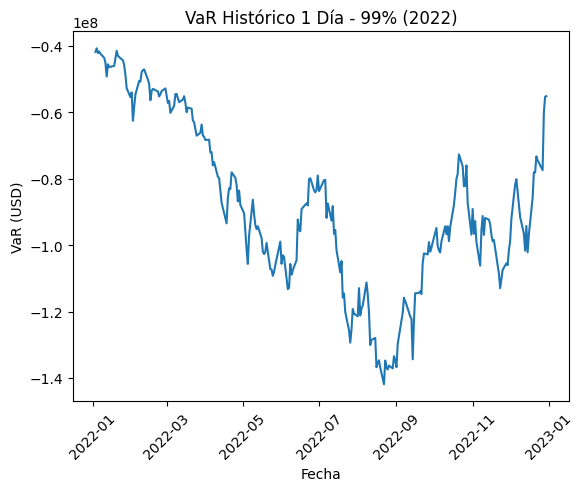

In [67]:
plt.figure()
plt.plot(df_2022["Date"], df_2022["VaR_USD"])
plt.title("VaR Histórico 1 Día - 99% (2022)")
plt.xlabel("Fecha")
plt.ylabel("VaR (USD)")
plt.xticks(rotation=45)
plt.show()


n este ejercicio se calculó el VaR histórico con un nivel de confianza del 99% para el año 2022, obteniéndose una estimación cercana al 13.5% diario. Este resultado puede parecer elevado; sin embargo, es consistente con la alta volatilidad observada en el mercado de Henry Hub Natural Gas durante 2022, periodo caracterizado por fuertes fluctuaciones y movimientos extremos en los precios.

Al ser el 99% de confianza teniamos el 1% de error por así decirlo, lo cual obtendriamos de 2 a 3 errores en nuestras observaciones. Esto nos quiere decir que el valor esperado con el número real de observaciones en las que la pérdida superó el VaR, se concluye que el modelo no es congruente con el nivel de confianza establecido. Si el número de violaciones fue superior al esperado, esto sugiere que el VaR histórico subestimó el riesgo durante el periodo analizado y no logró capturar completamente la magnitud de los eventos extremos.